In [1]:
# coding=utf-8
%matplotlib inline
import numpy as np
import matplotlib,sys
import matplotlib.pyplot as plt
matplotlib.rcParams['agg.path.chunksize'] = 10000
sys.path.append('/disk1/home/wangrj/.local/lib/python3.7/site-packages')
from time import *
import pylab
from tqdm import tqdm
from scipy import special,integrate,linalg
from multiprocessing import Pool 
import emcee
import corner

from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from dynesty.utils import quantile as _quantile

from pycbc import types,fft,frame
from pycbc.conversions import q_from_mass1_mass2,mchirp_from_mass1_mass2,primary_mass,secondary_mass
from pycbc.conversions import mass1_from_mchirp_q,mass2_from_mchirp_q
import Cosmology
import LISAConstants as LC
from pyFDresponse import *
from tdi import noisepsd_T,noisepsd_AE


In [2]:
#generate the template waveform
##MBHBs parameters
z=1
m1s=2e5
m2s=2e4

#dimensionless spins: a=cos(theta_s)*s
chi1 = 0.0
chi2 = 0.0

#Tcs = 0.8 * LC.YRSID_SI
t0= np.random.uniform(0.0,5.0)
t0=0.05
#Ecliptic Longitude, Latitude
theta=1.0
phi=1.5
lambd =  phi 
beta = np.pi/2 -theta

print('lambd,beta',lambd,beta)
inc = 0.5
DL = Cosmology.DL(z, w=0)[0] # in Mpc
print('Dl',DL)

#phi0 = np.random.uniform(0.0, 2.0*np.pi)
#psi = np.random.uniform(0.0, 2.0*np.pi)   #pols=psi
psi=0.8
phi0=0.0
print('t0,phi0,psi',t0,phi0,psi)
# So far, the only choice implemented: MLDC trajectories and TDI XYZ
[fRef, trajdict, TDItag] = [0., trajdict_MLDC, "TDIAET"]


#Masses quoted in the hdf5 files are always redshifted masses.
# m1 =  m1s*(1+z)  ### redshifted masses
# m2 =  m2s*(1+z)
m1=m1s
m2=m2s
print('m1,m2',m1,m2)
chirpmass=mchirp_from_mass1_mass2(m1,m2)
q=q_from_mass1_mass2(m1,m2)
print(chirpmass,q)
print(mass1_from_mchirp_q(chirpmass,q),mass2_from_mchirp_q(chirpmass,q))

apx=['SEOBNRv4HM','IMRPhenomXHM']
modes=[[[2,2]],[[2,2],[2,1],[3,2],[3,3],[4,4]]] 


variable = [
            #'chirpmass',
            #'q',
            'distance',
            'inc',
            'lambd',
            'beta'
            ]

truth=[DL,inc,lambd,beta]

lambd,beta 1.5 0.5707963267948966
Dl 6823.090480179816
t0,phi0,psi 0.05 0.0 0.8
m1,m2 200000.0 20000.0
49289.164742357876 10.0
200000.00000000006 20000.000000000007


In [3]:
delta_lambd=0.003
delta_beta=0.005
delta_phi=delta_lambd
thetamax=theta + delta_beta
thetamin = theta -delta_beta
omega=2*delta_phi * (np.cos(thetamin)-np.cos(thetamax))
print(omega,'rad^2')
print(omega/(2*np.pi)**2*360**2,'deg^2')

omega1= 2*np.pi*np.sin(beta)*np.sqrt(delta_lambd**2*delta_beta**2)
print(omega1/(2*np.pi)**2*360**2,'deg^2')

5.048804872099e-05 rad^2
0.1657424869409683 deg^2
0.16716802565212685 deg^2


In [4]:
num=21
res1=np.load('TDIfig/noHM/%d/sampler_results.npy'%num,allow_pickle=True)
try:
    weights = np.exp(res1.item()['logwt'] - res1.item()['logz'][-1])
except:
    weights = res1.item()['weights']

print(res1)
# print(res1.item()['logwt'])
# print(res1.item()['logz'][-1])
# print('weights',weights)
sample1= res1.item()['samples']
print(sample1.shape)


         nlive: 1000
         niter: 19192
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 21.252052372331917
       samples: array([[ 5.05838028e+02,  7.33596999e-01,  5.26015452e-01,
        -1.09904444e+00],
       [ 4.06510375e+02,  9.85009587e-01,  5.02416592e-01,
        -1.00141346e-02],
       [ 4.69582847e+02,  4.40143311e-01,  1.50974272e+00,
        -5.12312167e-01],
       ...,
       [ 6.64371569e+03,  5.34036761e-01,  1.50092543e+00,
         5.74347772e-01],
       [ 6.67299767e+03,  5.26357828e-01,  1.50105994e+00,
         5.74293406e-01],
       [ 1.37945451e+03,  1.72345096e+00,  1.50109531e+00,
         5.74336518e-01]])
    samples_id: array([418, 526, 398, ..., 512, 424,  70])
    samples_it: array([    0,     0,     0, ..., 17955, 18708, 18297], dtype=int32)
     samples_u: array([[0.01759299, 0.12861457, 0.01300773, 0.05461324],
       [0.00910345, 0.22357244, 0.0012083 , 0.49499302],
       [0.01449426, 0.04765469, 0.50487136, 0.25490306],
      

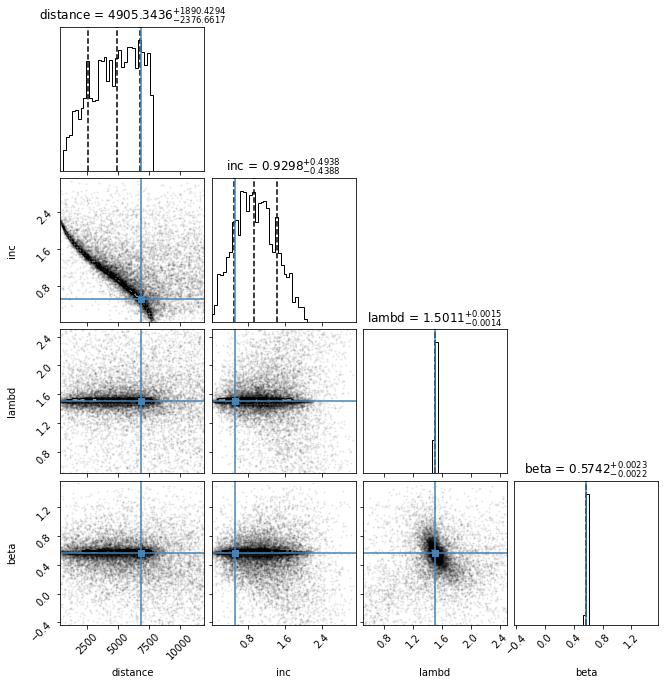

<IPython.core.display.Math object>

\mathrm{distance} = 5132.178_{-2630.127}^{2283.565}
\mathrm{inc} = 1.045_{-0.498}^{0.558}


<IPython.core.display.Math object>

\mathrm{lambd} = 1.502_{-0.047}^{0.080}


<IPython.core.display.Math object>

\mathrm{beta} = 0.573_{-0.158}^{0.048}


<IPython.core.display.Math object>

In [5]:

#print(weights)
#sample=np.load("TDIfig/noHM/%d/sample.npy"%num,allow_pickle=True)



para_range =[(300,12000),(0.0,np.pi),(lambd-1,lambd+1),(beta-1,beta+1)]
figure = corner.corner(sample1,truths=truth,labels=variable,bins=50,weights=weights,
                       quantiles=[0.16,0.5,0.84],show_titles=True,title_fmt='0.4f',
                       range=para_range)
#plt.savefig('TDIfig/noHM/%d/corner.png'%num,dpi=300)
plt.show()


from IPython.display import display, Math
labels=['distance','inclination','tc']
for i in range(len(variable)):
    mcmc = np.percentile(sample1[:, i], [16, 50, 84])
    qq = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], qq[0], qq[1], variable[i])
    print(txt)
    display(Math(txt))


In [26]:
label=('$D_{L}$','$\iota$','$\lambda$','$\\beta$')
print(variable)
print(label)


['distance', 'inc', 'lambd', 'beta']
('$D_{L}$', '$\\iota$', '$\\lambda$', '$\\beta$')


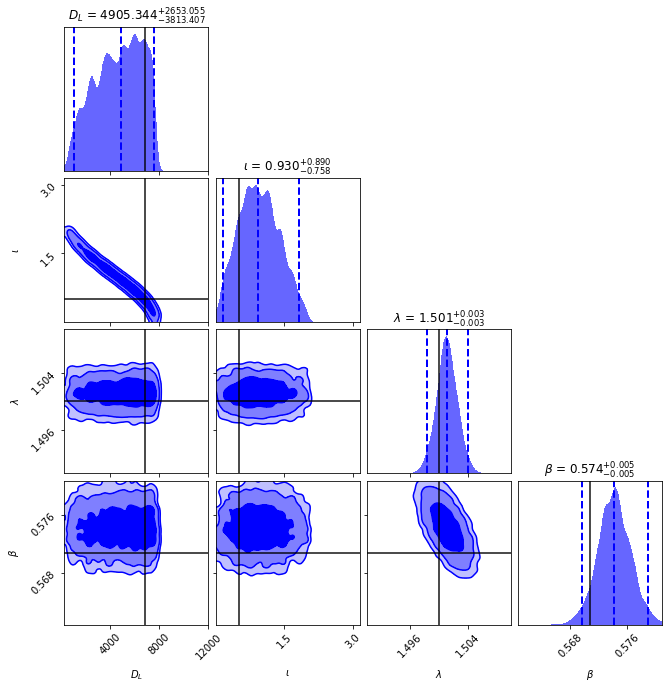

/disk1/home/wangrj/.local/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


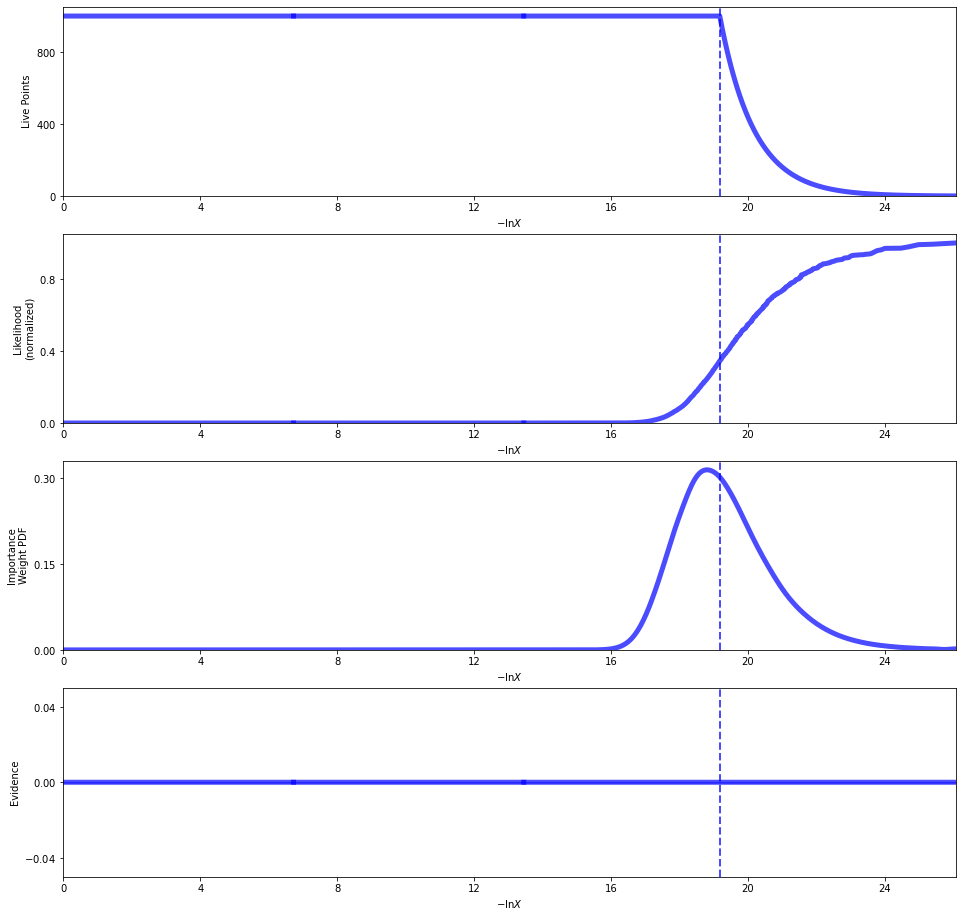

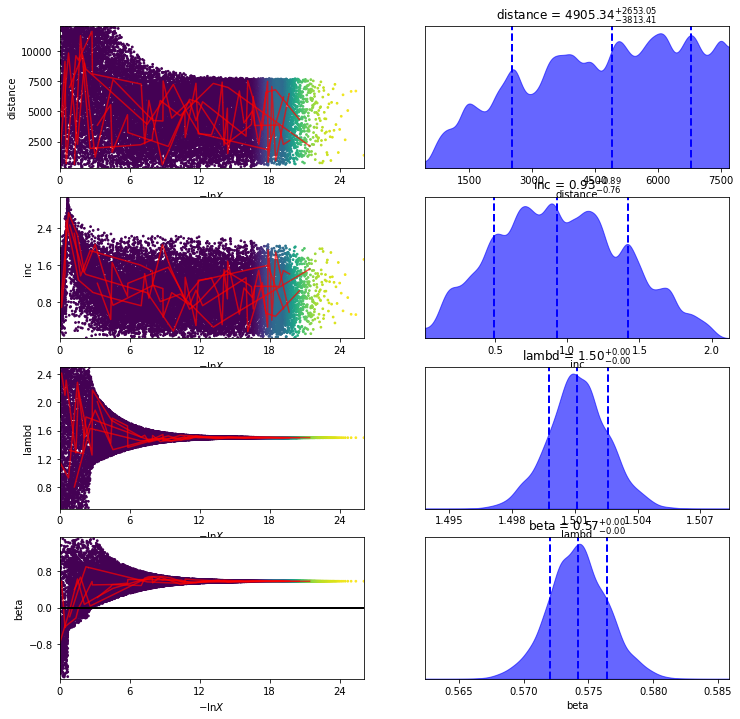

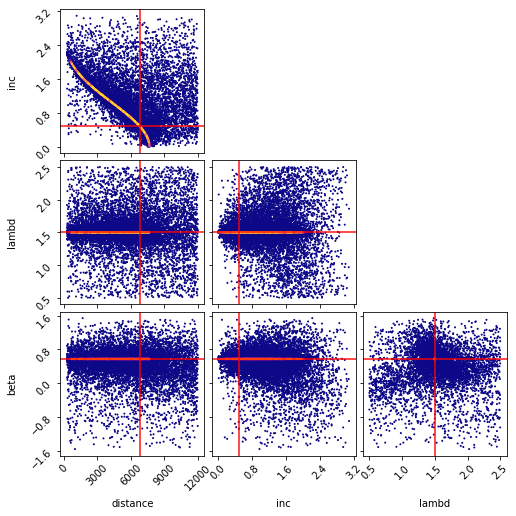

In [27]:
# np.savetxt('sampler_results.txt',res1)
# print(res1.item())
label=['$D_{L}$','$\iota$','$\lambda$','$\\beta$']
para_range =[(300,12000),(0.0,np.pi),(lambd-0.01,lambd+0.01),(beta-0.01,beta+0.01)]
#para_range =[(chirpmass-0.1,chirpmass+0.1),(q-0.000002,q+0.000002),(500,15000),(0.0,np.pi)]
fg, ax = dyplot.cornerplot(res1.item(), color='blue', truths=truth,
                           truth_color='black', show_titles=True,title_fmt='0.3f',
                           max_n_ticks=3, quantiles=[0.025,0.5,0.975],quantiles_2d=[0.68,0.95,0.99],
                           labels=label,span=para_range)
# ax[0][0].set(xlim=[1e5-0.1,1e5+0.1])
# ax[1][0].set(xlim=[1e5-0.1,1e5+0.1])
# ax[2][0].set(xlim=[1e5-0.1,1e5+0.1])
plt.savefig("TDIfig/noHM/%d/coner_plots.pdf"%num,dpi=300)
plt.show()

fig, axes = dyplot.runplot(res1.item())  # summary (run) plot
#plt.savefig("TDIfig/noHM/%d/summary_plots.png"%num,dpi=300)
plt.show()

fig, axes = dyplot.traceplot(res1.item(), truths=np.zeros(len(variable)),quantiles=[0.16,0.5,0.84],
                             truth_color='black', show_titles=True,labels=variable,
                             trace_cmap='viridis', connect=True,kde=False,
                             connect_highlight=range(5))
#axes[0][1].set(xlim=[1e5-100,1e5+100])
#plt.savefig("TDIfig/noHM/%d/trace_plots.png"%num,dpi=300)
plt.show()
fg, ax = dyplot.cornerpoints(res1.item(), cmap='plasma', truths=truth,labels=variable,
                             kde=False)
#plt.savefig("TDIfig/noHM/%d/coner_points.png"%num,dpi=300)
plt.show()

In [32]:
for i in range(len(variable)):
    ql, qm, qh = _quantile(sample1[:,i], [0.16, 0.5, 0.84], weights=weights)
    q_minus, q_plus = qm - ql, qh - qm
    print(variable[i],qm,q_minus,q_plus)

distance 4905.343579317972 2376.6617215563447 1890.4293911692885
inc 0.929810670143755 0.43880127630773885 0.4937952217559318
lambd 1.5011049907349974 0.0013552823097007227 0.0014573066744569818
beta 0.5741694318878668 0.0021741641294925618 0.0022919589027360354


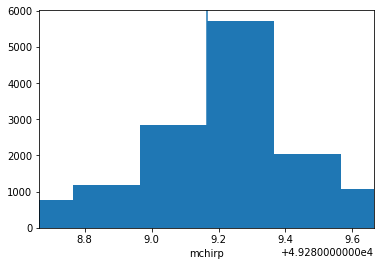

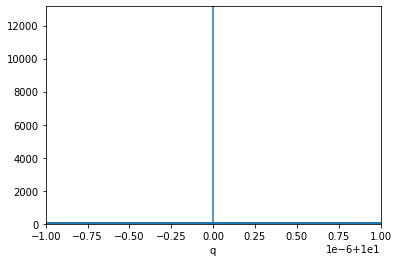

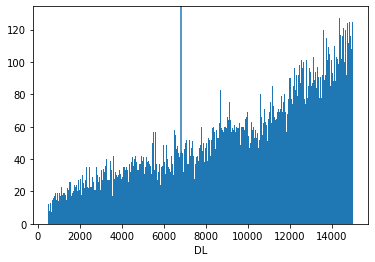

In [16]:
_ = pylab.hist(sample1[:,0], bins=100)
plt.axvline(x=chirpmass)
plt.xlim(chirpmass-0.5,chirpmass+0.5)
plt.xlabel('mchirp')
plt.show()

_ = pylab.hist(sample1[:,1], bins=50)
plt.axvline(x=q)
plt.xlim(q-0.000001,q+0.000001)
plt.xlabel('q')
plt.show()


_ = pylab.hist(sample1[:,2], bins=500)
plt.axvline(x=DL)

plt.xlabel('DL')
plt.show()

In [171]:
ID=0
Q3nod1=np.loadtxt('/disk1/home/wangrj/higherorder/catalogues/Q3nod%d'%ID)
j=488   #(51，129，134，158，310，316，372，417，447，483，590)

redshift,chirpmass, q,chi1,chi2,lambd,beta,inc,psi,phi0=Q3nod1[j]
DL = Cosmology.DL(redshift, w=0)[0] # in Mpc
print(j,Q3nod1[j])


variable = [
            #'chirpmass',
            #'q',
            'distance',
            'inc',
            'lambd',
            'beta'
            ]
truth=[DL,inc,lambd,beta]
para_range =[(DL*0.8,DL*1.2),(inc*0.5,inc*1.5),(lambd-0.5,lambd+0.5),(beta-0.5,beta+0.5)]


res2=np.load('result/Q3nod/%d/sampler_results_hm%d.npy'%(ID,j),allow_pickle=True)
try:
    weights2 = np.exp(res2.item()['logwt'] - res2.item()['logz'][-1])
except:
    weights2 = res2.item()['weights']

#print('weights',weights)
sample2= res2.item()['samples']

488 [ 1.48907957e+00  3.67372202e+04  2.79603232e+01  5.33512831e-01
 -6.33213644e-01  4.68026490e+00 -8.92732396e-01  2.68037479e-02
  4.87420004e+00  1.24709357e+00]


In [28]:
num=21
res2=np.load('TDIfig/HM/%d/sampler_results_hm.npy'%num,allow_pickle=True)
try:
    weights2 = np.exp(res2.item()['logwt'] - res2.item()['logz'][-1])
except:
    weights2 = res2.item()['weights']

#print('weights',weights)
sample2= res2.item()['samples']


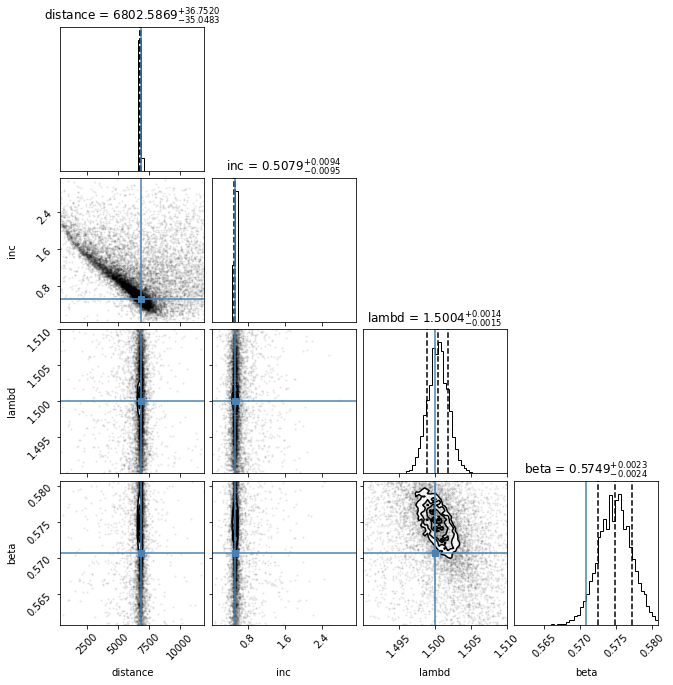

In [29]:

figure = corner.corner(sample2,truths=truth,labels=variable,bins=50,weights=weights2,
                       quantiles=[0.16,0.5,0.84],show_titles=True,title_fmt='0.4f',
                       range=para_range)
#plt.savefig('TDIfig/HM/%d/corner_hm.png'%num,dpi=300)
plt.show()

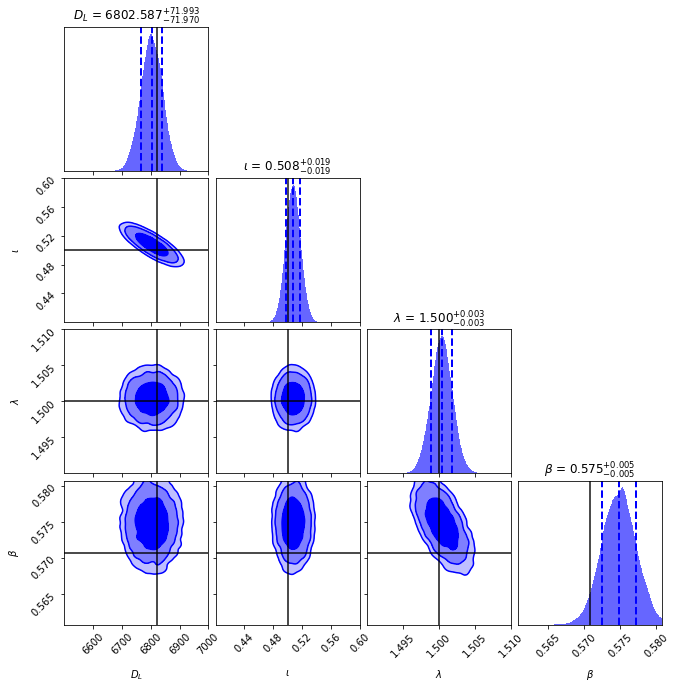

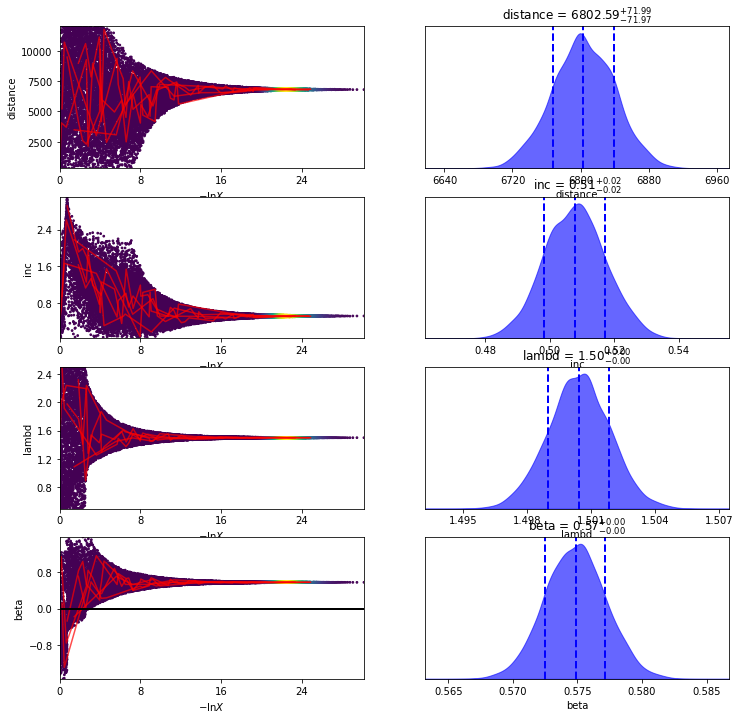

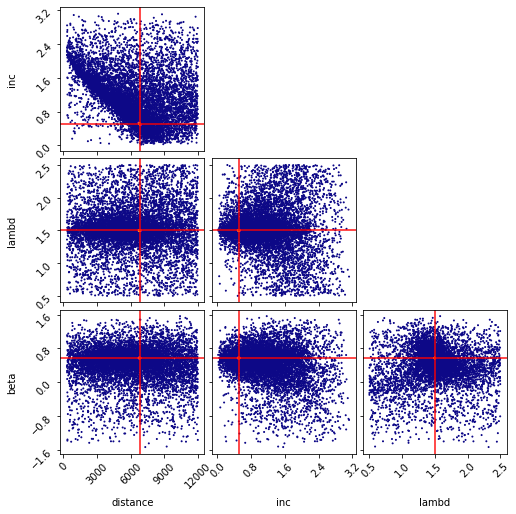

In [33]:
para_range =[(6500,7000),(0.4,0.6),(lambd-0.01,lambd+0.01),(beta-0.01,beta+0.01)]
#para_range =[(chirpmass-0.2,chirpmass+0.2),(q-0.000002,q+0.000002),(6400,7100),(0.95,1.08)]
fg, ax = dyplot.cornerplot(res2.item(), color='blue', truths=truth,
                           truth_color='black', show_titles=True,title_fmt='0.3f',
                           max_n_ticks=5, quantiles=[0.16,0.5,0.84],quantiles_2d=[0.68,0.95,0.99],
                           labels=label,span=para_range)
# ax[0][0].set(xlim=[1e5-1,1e5+1])
# ax[1][0].set(xlim=[1e5-1,1e5+1])
# ax[2][0].set(xlim=[1e5-1,1e5+1])
plt.savefig("TDIfig/HM/%d/coner_plots_hm.pdf"%num,dpi=300)
plt.show()

fig, axes = dyplot.traceplot(res2.item(), truths=np.zeros(len(variable)),quantiles=[0.16, 0.5, 0.84],
                             truth_color='black', show_titles=True,labels=variable,
                             trace_cmap='viridis', connect=True,
                             connect_highlight=range(5))
#axes[0][1].set(xlim=[chirpmass-1,chirpmass+1])
#plt.savefig("TDIfig/HM/%d/trace_plots_hm.png"%num,dpi=300)
plt.show()
fg, ax = dyplot.cornerpoints(res2.item(), cmap='plasma', truths=truth,labels=variable,kde=False)
#plt.savefig("TDIfig/HM/%d/coner_points_hm.png"%num,dpi=300)
plt.show()

In [31]:

mean, cov = dyfunc.mean_and_cov(sample2, weights2)
print(mean)
print(cov)
print(np.sqrt(cov))
del_DL= np.sqrt(cov[0][0])
print(del_DL)
print('del_DL/DL',del_DL/mean[0])

for i in range(len(variable)):
    ql, qm, qh = _quantile(sample2[:,i], [0.16, 0.5, 0.84], weights=weights2)
    q_minus, q_plus = qm - ql, qh - qm
    print(variable[i],qm,q_minus,q_plus)


DL_min,mean_DL,DL_max= _quantile(sample2[:,0], [0.16,0.5,0.84], weights=weights2)
del_DL= (DL_max-DL_min)/2
print(del_DL)
print('del_DL/DL',del_DL/mean_DL)
lambd_min,mean_lambd,lambd_max= _quantile(sample2[:,2], [0.16,0.5,0.84], weights=weights2)
beta_min,mean_beta,beta_max= _quantile(sample2[:,2], [0.16,0.5,0.84], weights=weights2)

delta_lambd= (lambd_max-lambd_min)/2
delta_beta= (beta_max-beta_min)/2

omega1= 2*np.pi*np.abs(np.sin(mean_beta))*np.sqrt(delta_lambd**2*delta_beta**2)
print(omega1,'rad^2')
print('omega',omega1/(2*np.pi)**2*360**2,'deg^2')
print(omega1/(2*np.pi)**2*360**2*60**2,'arc min^2')




[6.80320512e+03 5.07805001e-01 1.50041723e+00 5.74841982e-01]
[[ 1.33060869e+03 -3.12156011e-01 -1.46184069e-04  4.09693555e-04]
 [-3.12156011e-01  9.02922804e-05  7.49447801e-08 -1.47008055e-07]
 [-1.46184069e-04  7.49447801e-08  2.10614351e-06 -2.07389711e-06]
 [ 4.09693555e-04 -1.47008055e-07 -2.07389711e-06  5.53876541e-06]]
[[3.64775093e+01            nan            nan 2.02408882e-02]
 [           nan 9.50222502e-03 2.73760443e-04            nan]
 [           nan 2.73760443e-04 1.45125584e-03            nan]
 [2.02408882e-02            nan            nan 2.35345818e-03]]
36.477509342622824
del_DL/DL 0.005361812367275948
distance 6802.5869488346125 35.048338088857236 36.75199725292623
inc 0.5078615887588251 0.009538819191659886 0.009401582494819039
lambd 1.500430587339392 0.0014535627662526363 0.0014231382243283797
beta 0.574880661784498 0.0023621874291941403 0.002281640862410561
35.90016767089173
del_DL/DL 0.005277428710711589
1.296681352008609e-05 rad^2
omega 0.04256753776315675

/disk1/home/wangrj/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
